<a href="https://colab.research.google.com/github/YooJung-Moon/K-melon/blob/main/ResNet50_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Library

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import load_img, img_to_array, array_to_img
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd "/content"
# # %cd "/content/drive/MyDrive"
# !mkdir img

/content


### Data Download

In [ ]:
!wget https://www.dropbox.com/s/diwzbpumn81dwhd/img4.zip?dl=0

--2023-06-19 23:50:42--  https://www.dropbox.com/s/diwzbpumn81dwhd/img4.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/diwzbpumn81dwhd/img4.zip [following]
--2023-06-19 23:50:42--  https://www.dropbox.com/s/raw/diwzbpumn81dwhd/img4.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9b7d6766a973988849db4cfd8b.dl.dropboxusercontent.com/cd/0/inline/B-XGVMt5K3X4FKknWj_Ajg2NnsM_HUDVwoYinf8GPkBCIupz9qYGCdIl2sd1q719r9MFR6MO3QTP8_dO25CY7h24MAIP6U0kBoVHn8vpfF7TBmuVDIvzNaNiailOGfhzXBBpgLVIA29jfqQmb3kRWrboKy0whEnyphhLVCF6p2J2QQ/file# [following]
--2023-06-19 23:50:43--  https://uc9b7d6766a973988849db4cfd8b.dl.dropboxusercontent.com/cd/0/inline/B-XGVMt5K3X4FKknWj_Ajg2NnsM_HUDVwoYinf8GPkBCIupz9qYGCdIl2sd1q719r9MFR6MO3QTP8_dO25CY

In [ ]:
# !unzip '/content/drive/MyDrive/deeplearning/img4.zip' -d '/content/img'
!unzip '/content/img4.zip?dl=0'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: img4/val/정상/S027-FM02-027-2022-06-28-000074.jpg  
  inflating: __MACOSX/img4/val/정상/._S027-FM02-027-2022-06-28-000074.jpg  
  inflating: img4/val/정상/S026-FM02-026-2022-06-28-000043.jpg  
  inflating: __MACOSX/img4/val/정상/._S026-FM02-026-2022-06-28-000043.jpg  
  inflating: img4/val/정상/S051-FM03-051-2022-07-05-000049.jpg  
  inflating: __MACOSX/img4/val/정상/._S051-FM03-051-2022-07-05-000049.jpg  
  inflating: img4/val/정상/S009-FM01-009-2022-06-27-000092.jpg  
  inflating: __MACOSX/img4/val/정상/._S009-FM01-009-2022-06-27-000092.jpg  
  inflating: img4/val/정상/S024-FM02-024-2022-06-28-000005.jpg  
  inflating: __MACOSX/img4/val/정상/._S024-FM02-024-2022-06-28-000005.jpg  
  inflating: img4/val/정상/S034-FM02-034-2022-07-09-000016.jpg  
  inflating: __MACOSX/img4/val/정상/._S034-FM02-034-2022-07-09-000016.jpg  
  inflating: img4/val/정상/S010-FM01-010-2022-06-30-000043.jpg  
  inflating: __MACOSX/img4/

### Data preprocessing

In [ ]:
epochs = 50
batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

Data Augmentation

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          shear_range = 60,                                                                                                                    # shear_range = 60,
                                                          brightness_range = (0.8,1.2),
                                                          horizontal_flip = True)
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
train_set = train_gen.flow_from_directory(directory="/content/img4/train",
                                        target_size = (IMG_WIDTH,IMG_HEIGHT),
                                        class_mode='categorical',
                                        batch_size = batch_size)
val_set = img_gen.flow_from_directory(directory="/content/img4/val",
                                        target_size = (IMG_WIDTH,IMG_HEIGHT),
                                        class_mode='categorical',
                                        batch_size = batch_size)
test_set = img_gen.flow_from_directory(directory="/content/img4/test",
                                        target_size = (IMG_WIDTH,IMG_HEIGHT),
                                        class_mode='categorical',
                                        batch_size = batch_size)

Found 32855 images belonging to 5 classes.
Found 8268 images belonging to 5 classes.
Found 1670 images belonging to 5 classes.


### Build Transfer Model

Load ResNet50, except fc layer(include_top = False)

In [ ]:
model_res50 = applications.ResNet50(weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model_res50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [ ]:
x = model_res50.output
x = GlobalAveragePooling2D()(x)

x = Flatten()(x)

predictions = Dense(5, activation='softmax')(x)

model_transfer = Model(inputs=model_res50.input, outputs=predictions)

In [ ]:
model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [ ]:
model_transfer.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(
              learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
history = model_transfer.fit(train_set, epochs=epochs, batch_size = batch_size,validation_data=val_set)

Epoch 1/50
1027/1027 [==============================] - 483s 426ms/step - loss: 0.2688 - accuracy: 0.9035 - val_loss: 0.3656 - val_accuracy: 0.8538
Epoch 2/50
1027/1027 [==============================] - 433s 422ms/step - loss: 0.1572 - accuracy: 0.9464 - val_loss: 0.1853 - val_accuracy: 0.9516
Epoch 3/50
1027/1027 [==============================] - 433s 421ms/step - loss: 0.1343 - accuracy: 0.9534 - val_loss: 0.1078 - val_accuracy: 0.9657
Epoch 4/50
1027/1027 [==============================] - 430s 419ms/step - loss: 0.1229 - accuracy: 0.9571 - val_loss: 0.0994 - val_accuracy: 0.9701
Epoch 5/50
1027/1027 [==============================] - 432s 421ms/step - loss: 0.1101 - accuracy: 0.9618 - val_loss: 0.1124 - val_accuracy: 0.9659
Epoch 6/50
1027/1027 [==============================] - 427s 416ms/step - loss: 0.1051 - accuracy: 0.9644 - val_loss: 0.1244 - val_accuracy: 0.9586
Epoch 7/50
1027/1027 [==============================] - 435s 423ms/step - loss: 0.0960 - accuracy: 0.9667 - val_

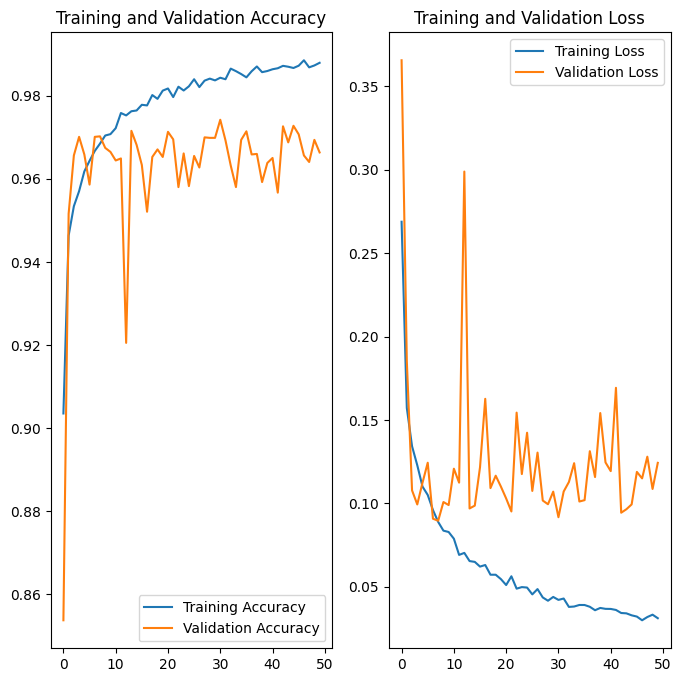

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')

plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# %cd "/content/drive/MyDrive/deeplearning"
# model_transfer.save("Transferlearning_ResNet50.h5")

/content/drive/MyDrive/deeplearning


In [ ]:
# from keras.models import load_model
# model_transfer = load_model('/content/drive/MyDrive/deeplearning/Transfer_ResNet50.h5')

In [ ]:
model_transfer.evaluate(test_set)

53/53 [==============================] - 6s 112ms/step - loss: 0.7948 - accuracy: 0.8437


[0.7947937250137329, 0.843712568283081]

In [ ]:
images = []
labels = []

def load_image():
  global images, labels
  dir = "/content/img4/test/"
  class_dir = ['노균병','노균병유사','정상','흰가루병','흰가루병유사']
  for index in range(len(class_dir)):
    list_dir = dir+class_dir[index]+"/"
    for j in os.listdir(list_dir):
      if j == ".ipynb_checkpoints":
        continue
      img = load_img(list_dir+j)
      test_array = img_to_array(img)
      test_x = tf.expand_dims(img,0)
      images.append(test_x)
      labels.append(index)
load_image()
labels = np.array(labels)

In [ ]:
y = []
for i in range(len(images)):
  predictions = model_transfer.predict(images[i]/255)
  pred = np.argmax(predictions)
  y.append(pred)
class_names = list(test_set.class_indices.keys())
confusion_matrix = confusion_matrix(y, labels)
print(confusion_matrix)
print('Classification Report:')
print(classification_report(y, labels, target_names=class_names))

1/1 [==============================] - 0s 22ms/step
[[339   0   0   9   0]
 [ 52 273   0  32  10]
 [  8  90 399   0  22]
 [  0   1   0 357   1]
 [  0  35   0   1  41]]
Classification Report:
                precision    recall  f1-score   support

      노균병       0.85      0.97      0.91       348
  노균병유사       0.68      0.74      0.71       367
        정상       1.00      0.77      0.87       519
    흰가루병       0.89      0.99      0.94       359
흰가루병유사       0.55      0.53      0.54        77

      accuracy                           0.84      1670
     macro avg       0.80      0.80      0.79      1670
  weighted avg       0.86      0.84      0.84      1670



In [ ]:
model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           